In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os
import tensorflow as tf
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
    Activation,
    BatchNormalization,
    Input,
    GlobalAveragePooling2D,
)
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

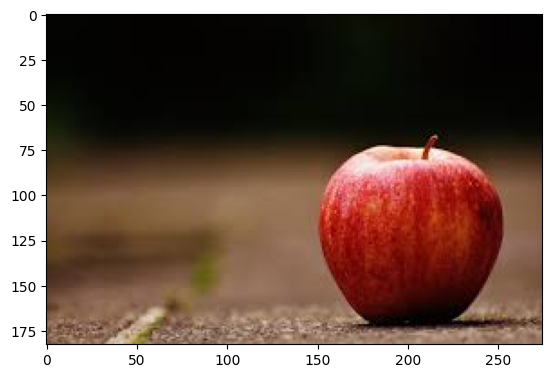

In [147]:
dataset_dir = "../data/fruit/MY_data"
train_path = os.path.join(dataset_dir, "train")
test_path = os.path.join(dataset_dir, "test")
img = load_img(train_path + "/Apple/img_01.jpeg")
plt.imshow(img)
plt.axis("on")
plt.show()

In [148]:
img = img_to_array(img)
img.shape

(183, 275, 3)

In [149]:
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
baseModel.trainable = False


model = Sequential(
    [
        baseModel,
        GlobalAveragePooling2D(),
        Dense(
            128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)
        ),
        BatchNormalization(),
        Dropout(0.3),
        Dense(
            64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)
        ),
        BatchNormalization(),
        Dropout(0.3),
        Dense(
            32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)
        ),
        Dense(10, activation="softmax"),
    ]
)
model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_43 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_26 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                     

In [150]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [151]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1
)
model_checkpoint = ModelCheckpoint(
    "../exported_models/best_fruit_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

Found 1841 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.
Found 460 images belonging to 10 classes.


In [152]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
)

Epoch 1/20
58/58 [==============================] - ETA: 0s - loss: 2.4763 - accuracy: 0.1711
Epoch 1: val_loss improved from inf to 2.11112, saving model to ../exported_models\best_fruit_model.h5


f:\WORK_Year_2\IS\neuron_activated\env_tensor\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 36s 569ms/step - loss: 2.4763 - accuracy: 0.1711 - val_loss: 2.1111 - val_accuracy: 0.3152 - lr: 1.0000e-04
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 2.1154 - accuracy: 0.2770
Epoch 2: val_loss improved from 2.11112 to 1.86664, saving model to ../exported_models\best_fruit_model.h5
58/58 [==============================] - 32s 553ms/step - loss: 2.1154 - accuracy: 0.2770 - val_loss: 1.8666 - val_accuracy: 0.4674 - lr: 1.0000e-04
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 1.8735 - accuracy: 0.3813
Epoch 3: val_loss improved from 1.86664 to 1.62263, saving model to ../exported_models\best_fruit_model.h5
58/58 [==============================] - 31s 541ms/step - loss: 1.8735 - accuracy: 0.3813 - val_loss: 1.6226 - val_accuracy: 0.5804 - lr: 1.0000e-04
Epoch 4/20
58/58 [==============================] - ETA: 0s - loss: 1.6593 - accuracy: 0.4612
Epoch 4: val_loss improved from 1.62263 to 1.42019, savin

In [184]:
model.save_weights("../exported_models/fruit_model.h5")

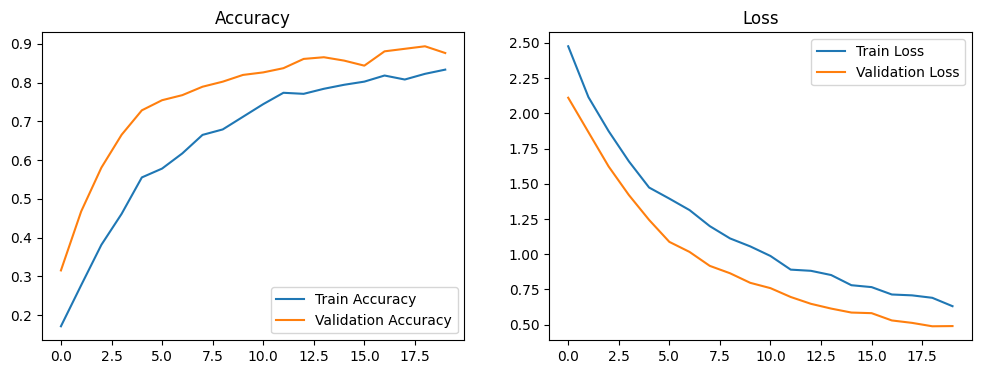

In [154]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [155]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

33/33 [==============================] - 9s 284ms/step - loss: 1.5283 - accuracy: 0.6498
Test accuracy: 0.6498


Testing on a random kiwi image: img_331.jpeg
1/1 [==============================] - 0s 31ms/step


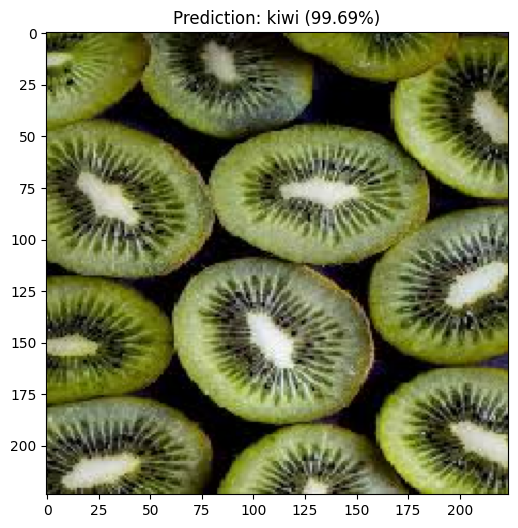

In [183]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


def predict_and_display(img_path):
    original_img, processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("on")
    plt.show()


import random

class_dirs = [
    d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))
]


random_class = random.choice(class_dirs)
class_path = os.path.join(test_path, random_class)

images = [f for f in os.listdir(class_path) if f.endswith((".jpg", ".jpeg", ".png"))]

random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

print(f"Testing on a random {random_class} image: {random_image}")
predict_and_display(img_path)